In [48]:
from dataclasses import dataclass, field
from typing import List, Set, Tuple, Any, Dict, DefaultDict, Optional, Callable, cast
import copy
import uuid
from collections import defaultdict
from itertools import permutations
import matplotlib.pyplot as plt
import random

In [49]:
class Unique:
    def __init__(self):
        self.id = uuid.uuid4()

    def __hash__(self):
        return hash(self.id)

class Call(Unique):
    def __init__(self, threadno, func, args, start, end):
        super().__init__()
        self.threadno : int = threadno
        self.func : str = func
        self.args : List[Any] = args
        self.start : int = start
        self.end : int = end
        self.order : Optional[int] = None
        self.timestamp = (self.start, self.end)

    def __repr__(self):
        return f'Call({self.threadno}, {self.func}, {self.args}, {self.start}, {self.end})'
    
    def __str__(self):
        return f'{self.func}({self.args})'
    
    def exec(self) -> Tuple['State', Any]:
        raise NotImplementedError

@dataclass
class State:
    def copy(self) -> 'State':
        raise NotImplementedError

In [50]:
def sort_by_thread(spec: List[Call]):
    threads : DefaultDict[int, List[Call]] = defaultdict(list)
    for c in spec:
        threads[c.threadno].append(c)
    return threads

def visualize_history(spec : List[Call]):
    # make the graph big enough so that the labels don't overlap
    fig, ax = plt.subplots(figsize=(20, 10))
    threads = sort_by_thread(spec)

    ax.set_yticks(range(max(threads.keys()) + 2))
    # leave margins on the top and bottom of the graph for the labels
    ax.set_ylim(-0.5, max(threads.keys()) + 1.5)

    for threadno, ops in threads.items():
        for op in ops:
            # draw the interval
            ax.plot([op.start , op.end], [threadno, threadno], color='black')
            # add little ticks at the start and end of the interval
            ax.plot([op.start, op.start], [threadno - 0.1, threadno + 0.1], color='black')
            ax.plot([op.end, op.end], [threadno - 0.1, threadno + 0.1], color='black')
            # draw the label slightly above the interval
            ax.text((op.start + op.end) / 2, threadno + 0.1, str(op), horizontalalignment='center', verticalalignment='center')
            # draw the order of the operation above the label in red
            if op.order is not None:
                ax.text((op.start + op.end) / 2, threadno + 0.25, str(op.order), horizontalalignment='center', verticalalignment='center', color='red')
    
    plt.show()

In [51]:
def linearize_generic(spec: List[Call], state: State):
    threads : DefaultDict[int, List[Call]] = sort_by_thread(spec)

    def helper(threads : DefaultDict[int, List[Call]], state: State):
        res : List[List[Call]] = []
        first_op_per_thread = [t[0] for t in threads.values() if t]
        if not first_op_per_thread:
            return res
        ref = first_op_per_thread.pop()
        candidates : List[Call] = [ref]
        while first_op_per_thread:
            op = first_op_per_thread.pop()
            if op.start >= ref.end:
                # if op starts after ref ends, then we cannot call op before ref, as that would violate the linearizability
                continue
            elif op.end <= ref.end:
                ref = op
                candidates.append(op)
                # we have to recheck all exisiting candidates, as they might be invalidated by the new ref
                for c in tuple(candidates):
                    if c.start >= ref.end:
                        candidates.remove(c)
            else:
                # other 2 cases are when op starts before ref ends, and when op ends after ref ends
                candidates.append(op)
            
        # now we just pop a candidate an proceed by recursion
        # print(f'candidates: {candidates}')
        for c in candidates:
            # print(f'candidate: {c}')

            new_state = state.copy()
            optional_state = c.exec(new_state)
            if optional_state is not None:
                new_state, _ = optional_state
            else:
                continue

            threads_copy = copy.deepcopy(threads)

            threads_copy[c.threadno].pop(0)
            sol = helper(threads_copy, new_state)
            if sol is not None:
                # since sol is a list of solutions, we need to add the current candidate to all of them
                # two cases:
                # 1. sol is empty, then we just add the candidate
                # 2. sol is not empty, then we add the candidate to all of them
                if sol == []:
                    res.append([c])
                else:
                    for s in sol:
                        s.insert(0, c)
                    res.extend(sol)
                    
        if not res:
            return None
        return res

    # sort threads by the start time of the first operation
    for t in threads.values():
        t.sort(key=lambda x: x.start)
    ret = helper(threads, state)
    if ret is None:
        return ret
    for i in range(len(ret)):
        for j in range(len(ret[i])):
            ret[i][j].order = j + 1
   
    return ret

In [52]:
# These are special cases for the queue example

@dataclass
class StateQueue(State):
    stack : List[Any] = field(default_factory = list)

    def copy(self):
        return StateQueue(stack=self.stack.copy())


class CallEnq(Call):
    def __init__(self, threadno, arg : int, start, end):
        super().__init__(threadno, "enq", [arg], start, end)

    def exec(self, state: StateQueue):
        state.stack.append(self.args[0])
        return state, None

class CallDeq(Call):
    def __init__(self, threadno, arg : int, start, end):
        super().__init__(threadno, "deq", [arg], start, end)

    def exec(self, state: StateQueue):
        if len(state.stack) == 0:
            return 
        e = state.stack.pop(0)
        if e != self.args[0]:
            return 
        return state, e

In [53]:
testq1 = [
    CallEnq(1, 1, 0, 2),
    CallDeq(1, 1, 2, 3),
    CallDeq(1, 2, 3, 4),
    CallDeq(1, 1, 4, 5),
    CallEnq(2, 1, 0, 1),
    CallEnq(2, 2, 1, 2),
]
        
testq2 = [
    CallEnq(1, 1, 0, 1),
    CallEnq(1, 2, 1, 2),
    CallEnq(1, 1, 2, 3),
    CallDeq(1, 1, 3, 5),
    CallDeq(2, 1, 3, 4),
    CallDeq(2, 2, 4, 5),
]

testq3 = [
    CallEnq(1, 1, 0, 1),
    CallEnq(1, 2, 1, 2),
    CallDeq(1, 1, 2, 3),
    CallEnq(2, 1, 0, 1),
    CallDeq(1, 2, 3, 4),
    CallDeq(2, 1, 1, 2),
]



In [54]:
# These are special cases for the i/o operations on the register example

@dataclass
class StateIO(State):
    value : Optional[int] = None

    def copy(self):
        return StateIO(value=self.value)

class CallWrite(Call):
    def __init__(self, threadno, arg : int, start, end):
        super().__init__(threadno, "write", [arg], start, end)

    def exec(self, state: StateIO):
        state.value = self.args[0]
        return state, None

class CallRead(Call):
    def __init__(self, threadno, arg : int, start, end):
        super().__init__(threadno, "read", [arg], start, end)

    def exec(self, state: StateIO):
        if state.value is None:
            return
        if state.value != self.args[0]:
            return
        return state, None

In [55]:
def linearize_io(spec: List[Call]):
    # Observations:
    # Lets label the interval between some return of a write and the call of the last read of the same variable as I. Now for every other variable, lets investigate where its writes and reads are in relation to I.
    # 1. If a write ends before I ends, the read must begin before I
    # 2. If a write begins after I starts, the read must end after I
    # 3. If a read begins before I ends, the write must end after I
    # 4. If a read ends after I starts, the write must start before I
    # Furthermore, we cannot have a read both before and after I.
    # If all these conditions are met, then we can linearize the program.
    
    threads : DefaultDict[int, List[Call]] = sort_by_thread(spec)
    # We have to get all the writes and reads for each variable
    # sort by start time and write should be first
    spec.sort(key=lambda x: -1 if isinstance(x, CallWrite) else x.start)
    sort_by_var : DefaultDict[int, List[Call]] = defaultdict(list)
    for c in spec:
        sort_by_var[c.args[0]].append(c)
    
    # corner cases
    for var, var_class in sort_by_var.items():
        # check that there is exactly one write for each variable
        assert sum([isinstance(c, CallWrite) for c in var_class]) == 1, f"Variable {var} has more than one write"
        # check that the the first read is after the write
        if len(var_class) > 1 and var_class[0].start >= var_class[1].end:
            return False
    
    intervals = {var[0].args[0]: (var[0].end, var[-1].start) for var in sort_by_var.values() if len(var) > 1 and var[0].end < var[-1].start }

    # pre-processing
    for var, var_class in sort_by_var.items():
        # we cut all the reads that are before the write to the beginning of the write
        i = 1
        while i < len(var_class) and var_class[i].start < var_class[0].start:
            var_class[i].start = var_class[0].start
            i += 1
    
    # we cut the end of the write to the end of the read that ends first
    for var, var_class in sort_by_var.items():
        if len(var_class) > 1:
            var_class[0].end = min(var_class[0].end, *(var_class[i].end for i in range(1, len(var_class))))



    # first we check cases 1 and 2. 
    for var, interval in intervals.items():
        for var_class in sort_by_var.values():
            if var == var_class[0].args[0]:
                continue
            assert isinstance(var_class[0], CallWrite), "Should never happen"
            if interval[0] <= var_class[0].end <= interval[1]:
                for var_read_i in range(1, len(var_class)):
                    if var_class[var_read_i].start >= interval[0]:
                        return False
            elif interval[0] <= var_class[0].start <= interval[1] :
                for var_read_i in range(1, len(var_class)):
                    if var_class[var_read_i].end <= interval[1]:
                        return False
    
    # we check cases 3 and 4
    for var, interval in intervals.items():
        for var_class in sort_by_var.values():
            if var == var_class[0].args[0]:
                continue
            assert isinstance(var_class[0], CallWrite), "Should never happen"
            for var_read_i in range(1, len(var_class)):
                if interval[0] <= var_class[var_read_i].start <= interval[1] and var_class[0].end <= interval[1]:
                    return False
                if interval[0] <= var_class[var_read_i].end <= interval[1] and var_class[0].start >= interval[0]:
                    return False
    
    return True

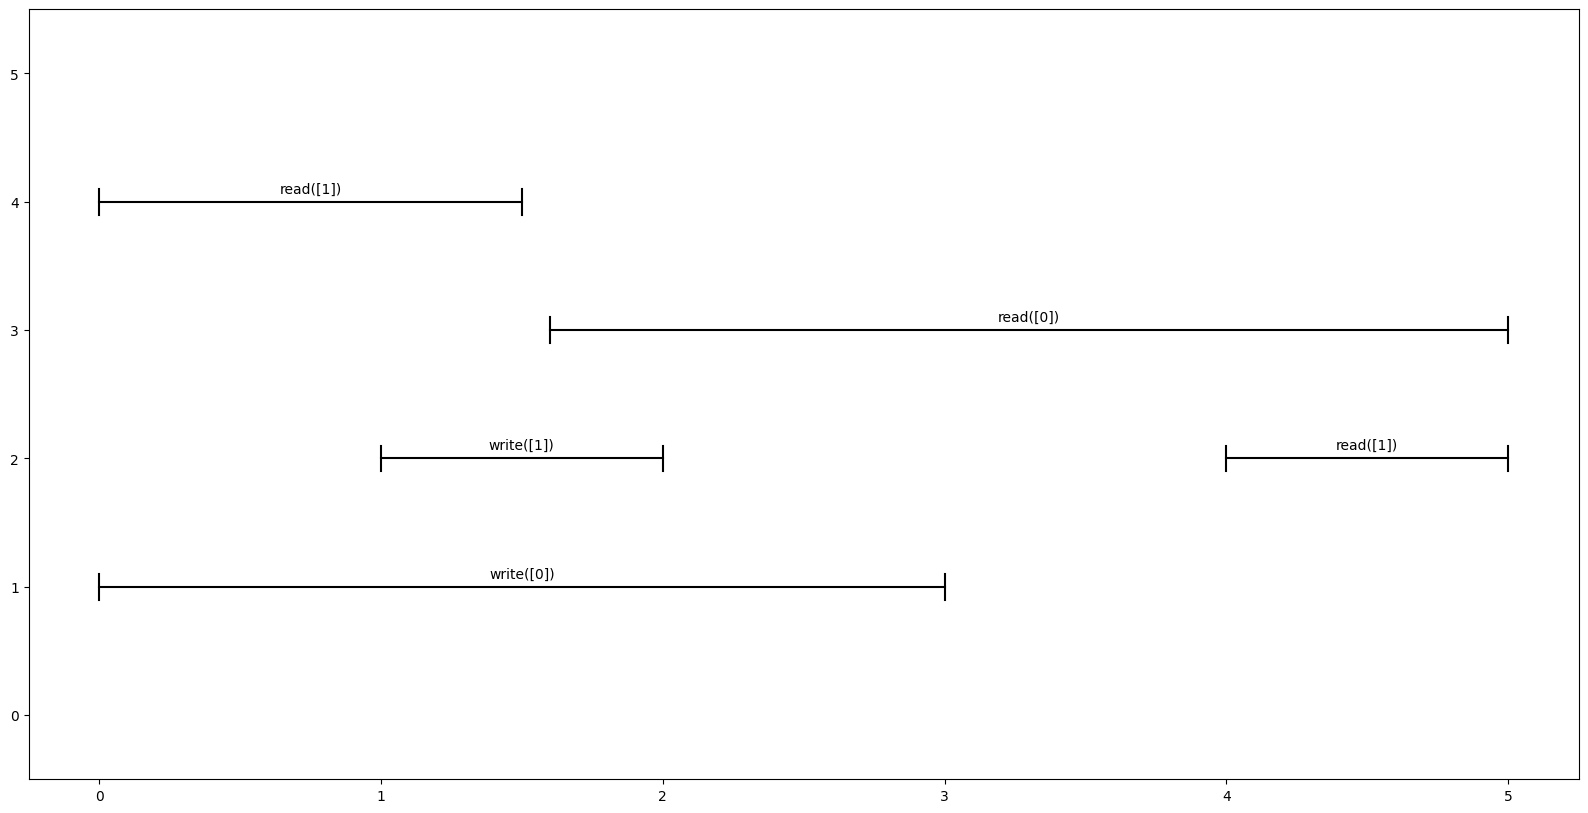

True
None


In [56]:
testio = [
    [
        CallWrite(1, 1, 0, 2),
        CallRead(2, 1, 0, 2)
    ],
    [
        CallWrite(1, 1, 0.7, 1),
        CallWrite(2, 2, 0.5, 3),
        CallRead(1, 2, 1.5, 3),
        CallRead(3, 1, 1, 3)
    ],
    [
        CallWrite(1, 0, 0, 3),
        CallWrite(2, 1, 1, 5),
        CallRead(3, 1, 1.5, 2.5),
        CallRead(1, 0, 3, 4),
        CallRead(3, 1, 4, 5)
    ],
    [
        CallWrite(1, 0, 0, 1),
        CallWrite(2, 1, 1, 5),
        CallRead(3, 1, 1.5, 2.5),
        CallRead(1, 0, 2, 4),
        CallRead(2, 1, 5, 6)
    ],
    [
        CallWrite(1, 0, 0, 3),
        CallWrite(2, 1, 1, 2),
        CallRead(3, 0, 1.6, 5),
        CallRead(4, 1, 0, 1.5),
        CallRead(2, 1, 4, 5)
    ], 
    [
        CallWrite(1, 0, 0, 3),
        CallWrite(2, 1, 1, 2.5),
        CallRead(3, 0, 2, 6),
        CallRead(2, 1, 4, 6),
    ]
]
             
i = 4
visualize_history(testio[i])
lin = linearize_generic(testio[i], StateIO())
print(linearize_io(testio[i]))
print(lin)

In [57]:
def generate_random_spec(n : int, m : int, p : int, ops: List[Callable]):
    """
    n is the number of threads\n
    m is the number of operations\n
    p is the number of variables\n
    the only constraint is that operations cannot overlap in time on the same thread
    """
    
    threads : DefaultDict[int, List[Call]] = defaultdict(list)
    for i in range(m):
        thread = random.randint(1, n)
        op = random.choice(ops)
        if len(threads[thread]) == 0:
            start = 0
        else:
            start = threads[thread][-1].end 
        # a random integer between 0 and 5
        start += random.randint(0, 5)
        end = start + random.randint(1, 10)
        threads[thread].append(op(thread, random.randint(0, p), start, end))
    return [c for thread in threads.values() for c in thread]

for i in range(5000):
    spec = generate_random_spec(4, 8, 4, [CallWrite, CallRead])
    if linearize_generic(spec, StateIO()):
        try:
            assert linearize_io(spec), f"Failed on {spec}"
        except AssertionError as e:
            if "more than one write" not in str(e):
                raise e


KeyboardInterrupt: 

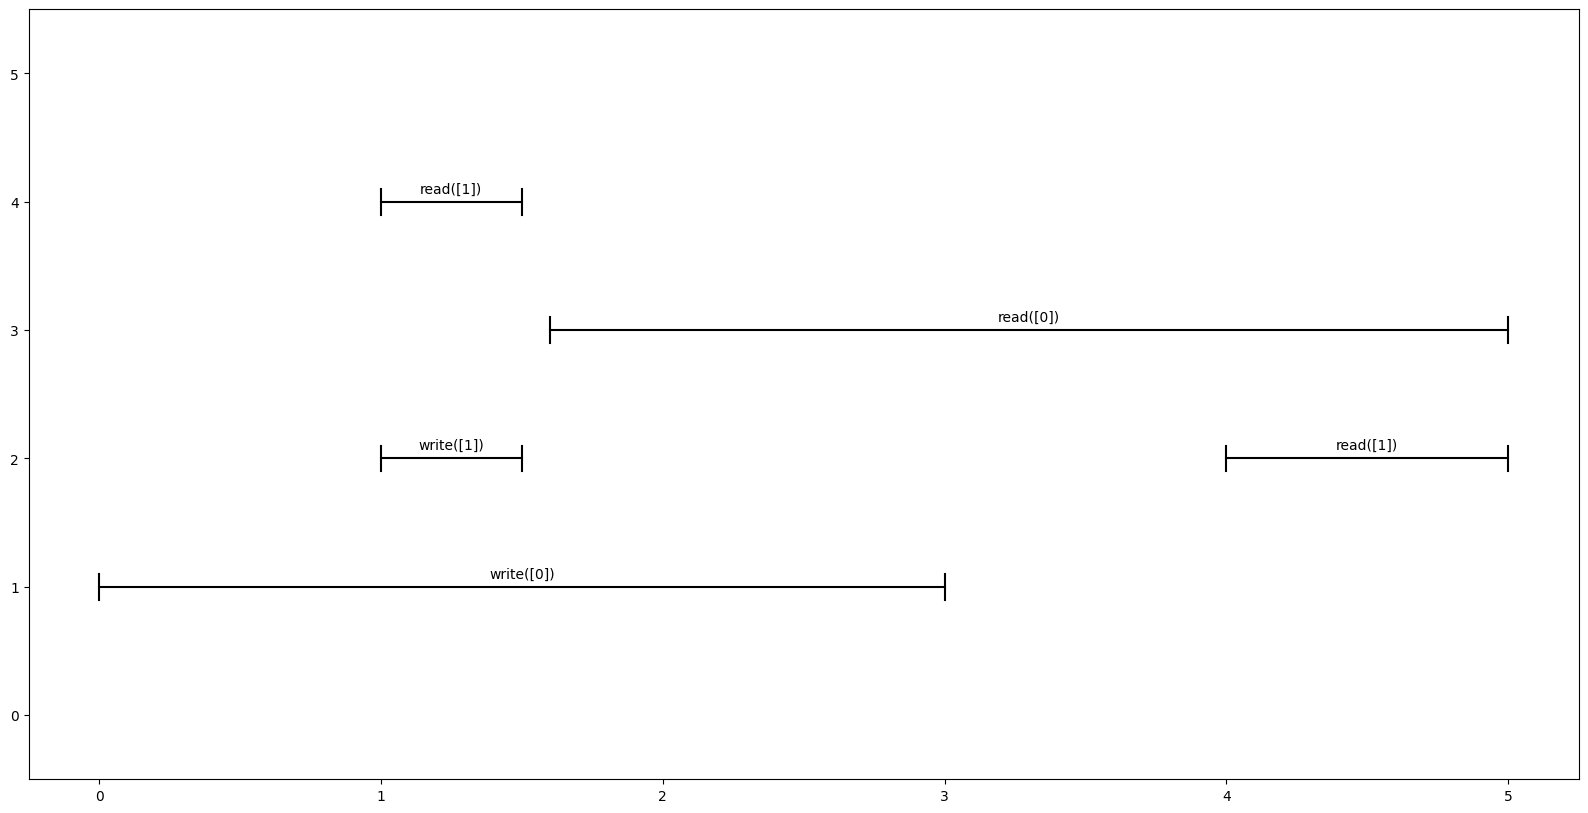

In [59]:
i = 4
# print(linearize_io(testio[i]))
visualize_history(testio[i])